<a href="https://colab.research.google.com/github/tom1484/keras-estimator/blob/master/keras-estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compare Estimator with Keras**

## **Basic definitions**

In [0]:
!pip install tensorflow==2.0.0b1
import tensorflow as tf
from tensorflow import data
from tensorflow import estimator
from tensorflow.keras import *

import numpy as np

     |████████████████████████████████| 87.9MB 35kB/s 
     |████████████████████████████████| 3.1MB 29.7MB/s 
     |████████████████████████████████| 501kB 47.8MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
# input_fn is an interface to feed data to the model
def input_fn(x, y, batch_size=None, num_epochs=None):
  dataset = data.Dataset.from_tensor_slices((x, y))
  if batch_size:
    dataset = dataset.batch(batch_size)
  if num_epochs:
    dataset = dataset.repeat(num_epochs)
  return dataset

In [0]:
input_shape = (28, 28, 1)
num_train = 60000
num_test = 10000

batch_size = 100
train_epochs = 10

## **Import dataset**

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# constraint the values between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# each image has only one channel
x_train.resize((len(x_train), ) + input_shape)
x_test.resize((len(x_test), ) + input_shape)

11493376/11490434 [==============================] - 0s 0us/step


## **Visualization of dataset**

In [0]:
import matplotlib.pyplot as plt

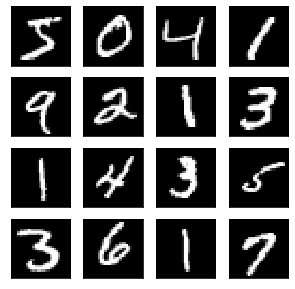

In [0]:
# show images in a 4 * 4 tables
n = 4 * 4
plt.figure(figsize=(5, 5))

for i in range(n):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i][:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **Model structure**

| Layer | Output Shape |
|:-|:-|
| conv2d | (None, 26, 26, 64) |
| max_pooling2d | (None, 13, 13, 64) |
| conv2d | (None, 11, 11, 32) |
| max_pooling2d | (None,  6, 6,  32) |
| conv2d | (None,  4, 4, 16) |
| flattem | (None, 256) |       
| dense | (None, 10) |   
    

## **Estimator**

The Estimator is a high-level API of Tensorflow, which was early added to Tensorflow in Release 1.1. It provides a abstraction over low-level operations, which enormously reduces the codes we need to write.

<p align="center"><img src="https://www.tensorflow.org/images/tensorflow_programming_environment.png" width="70%"></img></p>

Estimator provides some premade models such as DNNClassifier and LinearClassifier. You can also make your own model to be trained by write a custom **model_fn**. model_fn takes 4 parameters: **features**, **labels**, **mode** and **params**. The funtions of the 4 parameters will be explained later.

Below is an simple **image classfier** built with Estimator:



In [0]:
# this is the format of the definition of model_fn
def model_fn(features, labels, mode, params):

  # build model with keras.layers
  inputs = layers.Input(shape=input_shape)
  net = layers.Conv2D(32, 3, activation="relu")(inputs)
  net = layers.MaxPooling2D()(net)
  net = layers.Conv2D(16, 3, activation="relu")(net)
  net = layers.MaxPooling2D()(net)
  net = layers.Conv2D(8, 3, activation="relu")(net)
  net = layers.Flatten()(net)
  outputs = layers.Dense(10, activation="softmax")(net)

  # this part creates a way to feed data
  # I didn't notice that first time, so I used a tensor without any input
  model = models.Model(inputs, outputs)
  logits = model(features)

  y_pred = tf.argmax(logits, axis=1)

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=y_pred)
  else:
    cross_entropy = losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    loss = tf.reduce_mean(input_tensor=cross_entropy)

    optimizer = tf.compat.v1.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step=tf.compat.v1.train.get_global_step())

    metrics_dict = {"accuracy": tf.compat.v1.metrics.accuracy(labels, y_pred)}

    if mode == tf.estimator.ModeKeys.TRAIN:
      spec = tf.estimator.EstimatorSpec(mode=mode,
                                        loss=loss,
                                        train_op=train_op,
                                        eval_metric_ops=metrics_dict)
    elif mode == tf.estimator.ModeKeys.EVAL:
      spec = tf.estimator.EstimatorSpec(mode=mode,
                                        loss=loss,
                                        eval_metric_ops=metrics_dict)

    return spec

estimator_classfier = tf.estimator.Estimator(model_fn=model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpyt_di75h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f995c75e128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
train_input_fn = lambda: input_fn(x_train, y_train, batch_size=batch_size, num_epochs=train_epochs)
estimator_classfier.train(input_fn=train_input_fn, 
                          max_steps=num_train / batch_size * train_epochs)

eval_input_fn = lambda: input_fn(x_train, y_train, batch_size=batch_size, num_epochs=1)
estimator_classfier.evaluate(input_fn=eval_input_fn, 
                             steps=num_train / batch_size)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpyt_di75h/model.ckpt.
INFO:tensorflow:loss = 2.3033042, step = 0
INFO:tensorflow:global_step/sec: 26.6143
INFO:tensorflow:loss = 1.808445, step = 100 (3.759 sec)
INFO:tensorflow:global_step/sec: 27.6164
INFO:tensorflow:loss = 1.7463914, step = 200 (3.621 sec)
INFO:tensorflow:global_step/sec: 27.6935
INFO:tensorflow:loss = 1.6503816, step = 300 (3.611 sec)
INFO:tensorflow:global_step/sec: 27.5665
INFO:tensorflow:loss = 1.6263707, step = 400 (3.627 sec)
INFO:tens

{'accuracy': 0.88816667, 'global_step': 6000, 'loss': 1.5725749}

In [0]:
pred_input_fn = lambda: input_fn(x_test, y_test, batch_size=batch_size, num_epochs=1)
predict = estimator_classfier.predict(pred_input_fn)

# convert a predict object to an array
predict = [pred for pred in predict]

errors = 0
for i in range(num_test):
  if predict[i] != y_test[i]:
    errors += 1
print(f"final accuracy: {(1 - errors / num_test) * 100 :.2f}%")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpyt_di75h/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
final accuracy: 88.79%


## **Keras**

Keras is a model-level API, and doesn't handle low-level 
operations, which is the job of tensor manipulation libraries, or backends. Keras supports three backends - Tensorflow, Theano and CNTK.

<p align="center"><img src="https://3.bp.blogspot.com/-l2UT45WGdyw/Wbe7au1nfwI/AAAAAAAAD1I/GeQcQUUWezIiaFFRCiMILlX2EYdG49C0wCLcBGAs/s1600/image6.png" width="70%"></img></p>

As a deep learning library, Keras provides many deep learning model components such as layers, activation functions and optimizers, which similar to Estimator.
In fact, Keras wasn't added to Tensorflow until Release 1.4.0 (2017). Now, when you use tf.keras, you are simply using the Keras interface with the Tensorflow backend to build and train your model.

Below is an **autoencoder** built with Keras:

In [0]:
keras_classfier = models.Sequential([
  layers.Input(shape=input_shape),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(16, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(8, (3, 3), activation='relu'),
  layers.Flatten(),
  layers.Dense(10, activation="softmax")
])

keras_classfier.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
keras_classfier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 8)           1160      
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                7

In [0]:
train_input_fn = input_fn(x_train, y_train, batch_size=batch_size, num_epochs=train_epochs)
keras_classfier.fit(train_input_fn, 
                    steps_per_epoch=num_train / batch_size, 
                    epochs=train_epochs)

eval_input_fn = input_fn(x_train, y_train, batch_size=batch_size, num_epochs=1)
keras_classfier.evaluate(eval_input_fn)

Epoch 1/10
600/600 [==============================] - 21s 35ms/step - loss: 0.5027 - accuracy: 0.8445
Epoch 2/10
600/600 [==============================] - 21s 35ms/step - loss: 0.1563 - accuracy: 0.9531
Epoch 3/10
600/600 [==============================] - 21s 34ms/step - loss: 0.1097 - accuracy: 0.9671
Epoch 4/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0893 - accuracy: 0.9733
Epoch 5/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0770 - accuracy: 0.9769
Epoch 6/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0679 - accuracy: 0.9795
Epoch 7/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0614 - accuracy: 0.9812
Epoch 8/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0566 - accuracy: 0.9827
Epoch 9/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0529 - accuracy: 0.9840
Epoch 10/10
600/600 [==============================] - 7s 12ms/step - loss: 0.0470

[0.047005620267736956, 0.98525]

In [0]:
predict = keras_classfier.predict(x_test)
# each prediction is a 10d vector
predict = np.argmax(predict, axis=1)

errors = 0
for i in range(num_test):
  if predict[i] != y_test[i]:
    errors += 1
print(f"final accuracy: {(1 - errors / num_test) * 100 :.2f}%")

final accuracy: 98.15%


## **Important differences**

Usually people use estimator because of a important difference that you can conduct distributed training across multiple servers with the Estimators API, but not with Keras API.

According to **Tensorflow Estimators Guide**, it says that:

> You can run Estimator-based models on a local host or on a **distributed multi-server** environment without changing your model. Furthermore, you can run Estimator-based models on CPUs, GPUs, or TPUs without recoding your model.

## **Convert Keras to Estimator**

Both Estimator and Keras provides various models to work with and is easy to use. If you want to conduct distributed training across multiple servers, using Estimator is a better choice, but you can still work well with Keras because it provides the method: 

```
tf.keras.estimator.model_to_estimator
```

Below is an example of how to **convert a Keras model to an Estimator model**:

In [0]:
from_keras = tf.keras.estimator.model_to_estimator(keras_classfier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_uovurve', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f995bf343c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
train_input_fn = lambda: input_fn(x_train, y_train, batch_size=batch_size, num_epochs=train_epochs)
from_keras.train(input_fn=train_input_fn, 
                 max_steps=num_train / batch_size * train_epochs)

eval_input_fn = lambda: input_fn(x_train, y_train, batch_size=batch_size, num_epochs=1)
from_keras.evaluate(input_fn=eval_input_fn, 
                    steps=num_train / batch_size)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/tmp/tmp_uovurve/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: /tmp/tmp_uovurve/keras/keras_model.ckpt
INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.
INFO:tensorflow:Warm-started 8 variables.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_uovurve/model.ckpt.
INFO:tensorflow:loss = 0.05091175, step = 0
INFO:tensorflow:global_step/sec: 30.0125
INFO:tensorflow:loss = 0.07514346, step = 100 (3.335 sec)
INFO:tensorflow:global_step/sec: 30.4231
INFO:tensorflow:loss = 0.07333874, step = 200 (3.285 sec)
INFO:tensorflow:global_step/sec: 30.33

{'accuracy': 0.9893, 'global_step': 6000, 'loss': 0.031558644}

In [0]:
pred_input_fn = lambda: input_fn(x_test, y_test, batch_size=batch_size, num_epochs=1)
predict = from_keras.predict(pred_input_fn)

predict = [pred[list(pred.keys())[0]] for pred in predict]
predict = np.argmax(predict, axis=1)

errors = 0
for i in range(num_test):
  if predict[i] != y_test[i]:
    errors += 1
print(f"final accuracy: {(1 - errors / num_test) * 100 :.2f}%")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_uovurve/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
final accuracy: 98.32%
